In [162]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

features=["Plasma","BMI","AGE","PEDIGREE","BP","NOP","SERUM_INSULIN","TSKIN_THICKNESS","Target"]
attributesToClean = ["Plasma","BMI","BP"]

def load_data(path):
    diabetes = pd.read_csv(path,header=0)
    return diabetes

def load_diabetes_data():
    PATH = "datasets/Diabetes/pima-indians-diabetes.csv"
    diabetes_df = load_data(PATH)
    feature_names = diabetes_df.columns.array.copy()
    return diabetes_df,feature_names
    
def Separate_X_y_data(data):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    data = data.iloc[shuffled_indices]
    y = data[["Target"]]
    X = data.drop(columns='Target')
    return X,y

# This returns X_train, X_test, y_train, y_test
def produce_train_test_data(X,y,test_ratio):
    test_set_size = int(len(X)*test_ratio)
    return X[test_set_size:], X[:test_set_size],y[test_set_size:],y[:test_set_size]

class RemoveInvalidZeroValuesAttributes(BaseEstimator, TransformerMixin):
    def __init__(self,attributes):
        self.attributes = attributes
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        attrs = self.attributes
        for attribute in attrs:
            X= X[X[attribute]>0]
        return X

class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self,features):
        self.features = features
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        features = self.features
        X = X[features]
        return X

def preprocess_data(X,features,attributes):
    #data_preprocess_pipeline = Pipeline([("feature_selection",FeatureSelection(features)),("clean_zero",RemoveInvalidZeroValuesAttributes(attributes)),])
    data_preprocess_pipeline = Pipeline([("clean_zero",RemoveInvalidZeroValuesAttributes(attributes)),])
    X = data_preprocess_pipeline.fit_transform(X)
    return X

def scaleAndPreprocessData(data,features,attributes):
    data = preprocess_data(data,features,attributes)
    X,y = Separate_X_y_data(data)
    col = X.columns.array.copy()
    scaler = StandardScaler()
    X=scaler.fit_transform(X)
    X = pd.DataFrame(data=X,columns=col)
    return X, y
    
# trying chapter 7 concepts

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

def getPerformances(X_train, X_test, y_train, y_test):
    clf_name = []
    clf_performance = []
    rnd_clf = RandomForestClassifier()
    log_clf = LogisticRegression()
    svm_clf = SVC()
    tree_clf = DecisionTreeClassifier()
    KNN_clf = KNeighborsClassifier()
    gradient_clf = GradientBoostingClassifier()
    voting_clf = VotingClassifier(
        estimators = [('lr',log_clf),('rf',rnd_clf),('svc',svm_clf),('tree',tree_clf),('KNN',KNN_clf),('gradient',gradient_clf)],voting = 'hard')
    voting_clf.fit(X_train,y_train)
    for clf in (log_clf,rnd_clf,svm_clf,voting_clf,tree_clf,KNN_clf,gradient_clf):
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        clf_name.append(clf.__class__.__name__)
        score = accuracy_score(y_test,y_pred)
        clf_performance.append(score)
        print(clf.__class__.__name__,accuracy_score(y_test,y_pred))
    return clf_name,clf_performance
        
    
def getPerformanceCV(X_train, y_train):
    clf_name = []
    clf_performance = []
    rnd_clf = RandomForestClassifier()
    log_clf = LogisticRegression()
    svm_clf = SVC()
    tree_clf = DecisionTreeClassifier()
    KNN_clf = KNeighborsClassifier()
    gradient_clf = GradientBoostingClassifier()
    voting_clf = VotingClassifier(
        estimators = [('lr',log_clf),('rf',rnd_clf),('svc',svm_clf),('tree',tree_clf),('KNN',KNN_clf),('gradient',gradient_clf)],voting = 'hard')
    voting_clf.fit(X_train,y_train)
    for clf in (log_clf,rnd_clf,svm_clf,voting_clf,tree_clf,KNN_clf,gradient_clf):
        score = cross_val_score(clf,X_train,y_train,cv=4,scoring="accuracy").mean()
        clf_name.append(clf.__class__.__name__)
        clf_performance.append(score)
        print(clf.__class__.__name__,score)
    return clf_name,clf_performance
    
# TODO : Need to look into how to calculate AUC for voting classifier
def getAUCScore(X_train, y_train):
    clf_name = []
    clf_performance = []
    rnd_clf = RandomForestClassifier()
    log_clf = LogisticRegression()
    svm_clf = SVC()
    tree_clf = DecisionTreeClassifier()
    KNN_clf = KNeighborsClassifier()
    gradient_clf = GradientBoostingClassifier()
    voting_clf = VotingClassifier(
        estimators = [('lr',log_clf),('rf',rnd_clf),('svc',svm_clf),('tree',tree_clf),('KNN',KNN_clf),('gradient',gradient_clf)],voting = 'hard')
    voting_clf.fit(X_train,y_train)
    for clf in (log_clf,rnd_clf,svm_clf,voting_clf,tree_clf,KNN_clf,gradient_clf):
        name = clf.__class__.__name__
        if name in ['SVC','Logistic Regression']:
            y_scores = cross_val_predict(clf,X_train,y_train,cv=3, method="decision_function")
            score = roc_auc_score(y_train, y_scores)
        elif name in ['VotingClassifier']:
            score = cross_val_score(clf,X_train,y_train,cv=4,scoring="accuracy").mean()
        else:
            print(name)
            y_scores = cross_val_predict(clf,X_train,y_train,cv=3, method = "predict_proba")
            y_scores = y_scores[:,1]
            score = roc_auc_score(y_train, y_scores)
        clf_name.append(name)
        clf_performance.append(score)
        print(name,score)
    return clf_name,clf_performance


In [163]:
# Try with scaling
features=["Plasma","BMI","AGE","PEDIGREE","BP","NOP","SERUM_INSULIN","TSKIN_THICKNESS","Target"]
data, feature = load_diabetes_data()
X, y = scaleAndPreprocessData(data,features,attributesToClean)
X_train, X_test, y_train, y_test = produce_train_test_data(X,y,0.1)
name, performance = getPerformances(X_train, X_test, y_train, y_test)

# Try with scaling using CV
print("--------------------------now with CV---------------------------")
name, performance = getPerformanceCV(X_train, y_train)
print("--------------------------now with CV AUC---------------------------")
name, performance  = getAUCScore(X_train, y_train)

('LogisticRegression', 0.75)
('RandomForestClassifier', 0.7777777777777778)
('SVC', 0.7222222222222222)
('VotingClassifier', 0.7638888888888888)
('DecisionTreeClassifier', 0.8333333333333334)
('KNeighborsClassifier', 0.7222222222222222)


c:\python27\lib\site-packages\ipykernel_launcher.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
c:\python27\lib\site-packages\ipykernel_launcher.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


('GradientBoostingClassifier', 0.8194444444444444)
--------------------------now with CV---------------------------
('LogisticRegression', 0.7837569944377017)
('RandomForestClassifier', 0.7529782357298692)
('SVC', 0.7621522870818347)
('VotingClassifier', 0.7698871560971914)
('DecisionTreeClassifier', 0.685539294469291)
('KNeighborsClassifier', 0.7469467166553057)
('GradientBoostingClassifier', 0.7621804588018614)
--------------------------now with CV AUC---------------------------
LogisticRegression
('LogisticRegression', 0.8406011920186578)
RandomForestClassifier
('RandomForestClassifier', 0.76)
('SVC', 0.8151956465405545)
('VotingClassifier', 0.7744883830910565)
DecisionTreeClassifier
('DecisionTreeClassifier', 0.678258616221819)
KNeighborsClassifier
('KNeighborsClassifier', 0.7654884685151594)
GradientBoostingClassifier
('GradientBoostingClassifier', 0.8182327027727391)


In [164]:
# lets try without scaling

data, feature = load_diabetes_data()
data = preprocess_data(data,features,attributesToClean)
X,y = Separate_X_y_data(data)
X_train, X_test, y_train, y_test = produce_train_test_data(X,y,0.1)
name, performance = getPerformances(X_train, X_test, y_train, y_test)
# Try without scaling using CV
print("--------------------------now with CV---------------------------")
name, performance = getPerformanceCV(X_train, y_train)
print("--------------------------now with CV AUC---------------------------")
name, performance  = getAUCScore(X_train, y_train)

('LogisticRegression', 0.7777777777777778)
('RandomForestClassifier', 0.7777777777777778)
('SVC', 0.6944444444444444)


c:\python27\lib\site-packages\ipykernel_launcher.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('VotingClassifier', 0.8194444444444444)
('DecisionTreeClassifier', 0.8333333333333334)
('KNeighborsClassifier', 0.75)
('GradientBoostingClassifier', 0.8194444444444444)
--------------------------now with CV---------------------------


c:\python27\lib\site-packages\ipykernel_launcher.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


('LogisticRegression', 0.7561869253661861)
('RandomForestClassifier', 0.7530065229077649)
('SVC', 0.6518433772442701)
('VotingClassifier', 0.7469088464742861)
('DecisionTreeClassifier', 0.685539294469291)
('KNeighborsClassifier', 0.7208159453782677)
('GradientBoostingClassifier', 0.7621804588018614)
--------------------------now with CV AUC---------------------------
LogisticRegression
('LogisticRegression', 0.8258823529411764)
RandomForestClassifier
('RandomForestClassifier', 0.7586887794765483)
('SVC', 0.5799170769629438)
('VotingClassifier', 0.7499765620526007)
DecisionTreeClassifier
('DecisionTreeClassifier', 0.6823633065561026)
KNeighborsClassifier
('KNeighborsClassifier', 0.763192536926665)
GradientBoostingClassifier
('GradientBoostingClassifier', 0.817838818346722)


<BarContainer object of 7 artists>

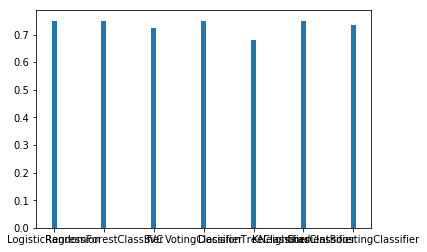

In [325]:
name, performance
plt.bar(name, performance,width=0.1)

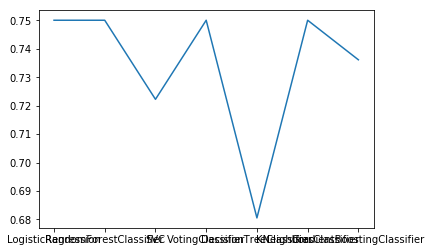

In [326]:
plt.plot(name,performance)

('BaggingClassifier', 0.7916666666666666)


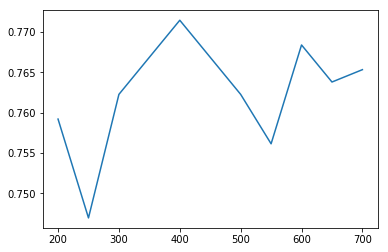

In [223]:
# Try with scaling
features=["Plasma","BMI","AGE","PEDIGREE","BP","NOP","SERUM_INSULIN","TSKIN_THICKNESS","Target"]
data, feature = load_diabetes_data()
X, y = scaleAndPreprocessData(data,features,attributesToClean)
X_train, X_test, y_train, y_test = produce_train_test_data(X,y,0.1)

# bagging classifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=100,max_samples=600,bootstrap=True,n_jobs=-1
)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__,accuracy_score(y_test,y_pred))

estomator_number=[]
scoreBag = []
for n_estimator in [200,250,300,350,400,450,500,550,600,650,700]:
    bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=n_estimator,max_samples=600,bootstrap=True,n_jobs=-1,oob_score=True)
    bag_clf.fit(X_train,y_train)
    y_pred = bag_clf.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    estomator_number.append(n_estimator)
    #scoreBag.append(score)
    scoreBag.append(bag_clf.oob_score_)

plt.plot(estomator_number,scoreBag)

In [225]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=400,max_samples=200,bootstrap=True,n_jobs=-1,oob_score=True
)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__,accuracy_score(y_test,y_pred))
print("oob score",bag_clf.oob_score_)

('BaggingClassifier', 0.8055555555555556)
('oob score', 0.7622699386503068)


In [179]:
# bagging classifier of sampling feature instead of sampling data

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=500,max_samples=1.0,bootstrap=False,n_jobs=-1,bootstrap_features=True,max_features=1.0
)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__,accuracy_score(y_test,y_pred))

('BaggingClassifier', 0.8055555555555556)


In [296]:
# Try with scaling
features=["Plasma","BMI","AGE","PEDIGREE","BP","NOP","SERUM_INSULIN","TSKIN_THICKNESS","Target"]
data, feature = load_diabetes_data()
X, y = scaleAndPreprocessData(data,features,attributesToClean)
X_train, X_test, y_train, y_test = produce_train_test_data(X,y,0.1)

# pasting classifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=350,max_samples=200,bootstrap=False,n_jobs=-1
)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__,accuracy_score(y_test,y_pred))

('BaggingClassifier', 0.8055555555555556)


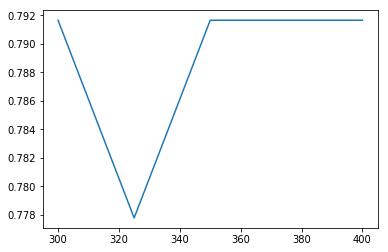

In [295]:
estomator_number=[]
scoreBag = []
for n_estimator in [300,325,350,375,400]:
    bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=n_estimator,max_samples=200,bootstrap=False,n_jobs=-1)
    bag_clf.fit(X_train,y_train)
    y_pred = bag_clf.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    estomator_number.append(n_estimator)
    scoreBag.append(score)

plt.plot(estomator_number,scoreBag)

In [240]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
rnd_clf.fit(X_train,y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test,y_pred_rf)

c:\python27\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.7777777777777778

In [247]:
rnd_clf.feature_importances_
featureNames  = X_train.columns.array.copy()
for name,score in zip(featureNames,rnd_clf.feature_importances_):
    print(name,score)

('NOP', 0.06512509169230594)
('Plasma', 0.35450716172407837)
('BP', 0.04380964070637186)
('TSKIN_THICKNESS', 0.04331297873857227)
('SERUM_INSULIN', 0.08205787719288458)
('BMI', 0.17235042734947642)
('PEDIGREE', 0.08385086566049263)
('AGE', 0.15498595693581801)


In [248]:
# try with selected features
# Try with scaling
features=["Plasma","BMI","AGE","PEDIGREE","BP","NOP","SERUM_INSULIN","Target"]
data, feature = load_diabetes_data()
X, y = scaleAndPreprocessData(data,features,attributesToClean)
X_train, X_test, y_train, y_test = produce_train_test_data(X,y,0.1)
name, performance = getPerformances(X_train, X_test, y_train, y_test)

('LogisticRegression', 0.75)
('RandomForestClassifier', 0.7777777777777778)
('SVC', 0.7222222222222222)


c:\python27\lib\site-packages\ipykernel_launcher.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('VotingClassifier', 0.7638888888888888)
('DecisionTreeClassifier', 0.8333333333333334)
('KNeighborsClassifier', 0.7222222222222222)
('GradientBoostingClassifier', 0.8194444444444444)


c:\python27\lib\site-packages\ipykernel_launcher.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [259]:
# not improving with selected features, now try ADA boosting

# Adaboost - Adaptive boost
#SAMME.R - Stagewise Additive Modeling using a multiclass exponential loss function
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
  DecisionTreeClassifier(max_depth=3),n_estimators=15, algorithm="SAMME.R", learning_rate=0.5
)

ada_clf.fit(X_train,y_train)
y_test_pred = ada_clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.8055555555555556

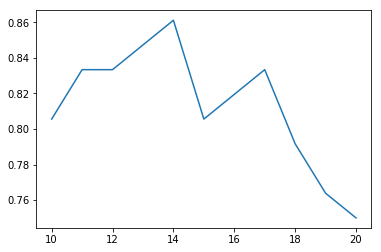

In [266]:
# check best number of estimator
estomator_number=[]
scoreBag = []
for n_estimator in [10,11,12,13,14,15,16,17,18,19,20]:
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=n_estimator, algorithm="SAMME.R", learning_rate=0.5)
    ada_clf.fit(X_train,y_train)
    y_pred = ada_clf.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    estomator_number.append(n_estimator)
    scoreBag.append(score)

plt.plot(estomator_number,scoreBag)

In [307]:
# with best estimator
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
  DecisionTreeClassifier(max_depth=3),n_estimators=14, algorithm="SAMME.R", learning_rate=0.5
)

ada_clf.fit(X_train,y_train)
y_test_pred = ada_clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.8611111111111112

In [270]:
#Gradient boosting or Gradient Tree Boosting Regression  Trees
gradient_clf = GradientBoostingClassifier(max_depth=60,n_estimators=100,learning_rate=1.0)
gradient_clf.fit(X_train,y_train)
y_test_pred = gradient_clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.8194444444444444

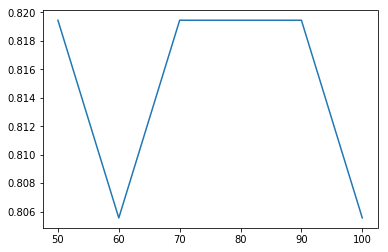

In [283]:
# check best number of estimator
estomator_number=[]
scoreBag = []
for n_estimator in [50,60,70,80,90,100]:
    gradient_clf = GradientBoostingClassifier(max_depth=60,n_estimators=n_estimator,learning_rate=1.0)
    gradient_clf.fit(X_train,y_train)
    y_pred = gradient_clf.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    estomator_number.append(n_estimator)
    scoreBag.append(score)

plt.plot(estomator_number,scoreBag)

In [286]:
#Gradient boosting with best estimator
gradient_clf = GradientBoostingClassifier(max_depth=60,n_estimators=80,learning_rate=1.0)
gradient_clf.fit(X_train,y_train)
y_test_pred = gradient_clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.8194444444444444

In [310]:
# trying chapter 8 concepts
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [311]:
pca.explained_variance_ratio_

array([0.25440964, 0.2326305 ])

In [314]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_) #Return the cumulative sum of the elements along a given axis.The default (None) is to compute the cumsum over the flattened array.
cumsum

array([0.25440964, 0.48704014, 0.61395801, 0.72410071, 0.8263627 ,
       0.89681484, 0.94978663, 1.        ])

In [316]:
dimension = np.argmax(cumsum > 0.95) + 1
dimension

8

In [319]:
# trying chapter 8 concepts
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
X2D_train = pca.fit_transform(X_train)

In [321]:
# Try with scaling
features=["Plasma","BMI","AGE","PEDIGREE","BP","NOP","SERUM_INSULIN","TSKIN_THICKNESS","Target"]
data, feature = load_diabetes_data()
X, y = scaleAndPreprocessData(data,features,attributesToClean)
pca = PCA(n_components=7)
X2D = pca.fit_transform(X)
X_train, X_test, y_train, y_test = produce_train_test_data(X2D,y,0.1)
name, performance = getPerformances(X_train, X_test, y_train, y_test)


('LogisticRegression', 0.75)
('RandomForestClassifier', 0.75)
('SVC', 0.7222222222222222)


c:\python27\lib\site-packages\ipykernel_launcher.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('VotingClassifier', 0.75)
('DecisionTreeClassifier', 0.6805555555555556)
('KNeighborsClassifier', 0.75)
('GradientBoostingClassifier', 0.7361111111111112)


c:\python27\lib\site-packages\ipykernel_launcher.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [ ]:
# Above is not any better than others